In [1]:
# import necessary libraries
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from scipy.sparse.linalg import eigsh
from scipy.signal import find_peaks
from scipy.spatial import Delaunay
from scipy.spatial import distance
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import multiprocessing as mp
from sklearn import metrics
import networkx as nx
import numpy as np
import random
import csv

In [2]:
def plot_points(P, labels, plot_tile, s) :
    plt.figure(figsize = (7, 7))
    plt.scatter(P[:,0], P[:,1], c = labels, cmap = 'rainbow_r', s = s)
    plt.gca().set_aspect('equal'), plt.title(plot_tile), plt.xlabel('x(mm)'), plt.ylabel('y(mm)')
    plt.show()

In [3]:
def plot_the_graph(G, P, plot_title, node_size):
    plt.figure(figsize=(7,7))
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    nx.draw(G, P, node_size=[node_size for v in range(P.shape[0])], node_color='lightgreen'
            ,edgelist=edges, edge_color=weights, width=5, edge_cmap=plt.cm.Blues)
    plt.title(plot_title)
    plt.gca().set_aspect('equal')
    plt.show()

In [4]:
def plot_clusters_with_graph(G, P, labels, plot_title, node_size):
    plt.figure(figsize=(7, 7))
    edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
    nodes = [i for i in G.nodes()]
    e = []
    w = []

    for i, edge in enumerate(edges):
        p1 = edge[0]
        p2 = edge[1]
        if labels[p1] == labels[p2] :
            e.append((p1, p2))
            w.append(1000)

    nx.draw(G, P, node_size=[node_size for v in range(P.shape[0])], node_color=labels[nodes], 
            cmap=plt.cm.rainbow_r ,edgelist=e, edge_color=w, width=1)
    plt.title(plot_title)
    plt.show()

In [5]:
def denoise(P, Sigma, sigma_s, noise_thrsh, plot_den_hist) :
    # Inputs : 
    # P_i           : [x, y], the localization centers
    # Sigma_i       : [[sigma_x_i, 0], [0, sigma_y_i]] where sigma_x_i and sigma_y_i are 
    # uncertinties in x and y direction  of the P_i localization respectively.
    # sigma_s       : scaling parameter
    # noise_thrsh   : threshold used for denoising
    # plot_den_hist : 0 or 1, 1 for when you want the density histogram plot
    
    n_points = P.shape[0]               # number of points
    sg2      = sigma_s ** 2 
    
    # ------- Constructing weighted graph -------
    dt = Delaunay(points=P)             # Delaunay triangulation for input points
    G  = nx.Graph()                     # G will be the weighted graph for the data
    
    for i in range(n_points):
        G.add_node(i)
    
    for path in dt.simplices:
        a  = path[0]
        b  = path[1]
        c  = path[2]
        d1 = np.exp(-(distance.euclidean(P[a], P[b])**2 + np.trace(Sigma[a] + Sigma[b]))/(2*sg2))
        d2 = np.exp(-(distance.euclidean(P[a], P[c])**2 + np.trace(Sigma[a] + Sigma[c]))/(2*sg2))
        d3 = np.exp(-(distance.euclidean(P[b], P[c])**2 + np.trace(Sigma[b] + Sigma[c]))/(2*sg2))
        G.add_weighted_edges_from([(a, b, d1)])
        G.add_weighted_edges_from([(a, c, d2)])
        G.add_weighted_edges_from([(b, c, d3)])
    
    # ------- Denosing -------
    degrees          = G.degree(weight=None)
    n_neighbors      = np.array([i for (_,i) in degrees]).ravel()
    weights          = G.degree(weight='weight')
    weighted_degrees = np.array([i for (_,i) in weights]).ravel()
    density          = np.nan_to_num(weighted_degrees/n_neighbors)

    not_noise_points = np.where(density>noise_thrsh)[0]
    noise_points     = np.where(density<=noise_thrsh)[0]
    
    # ------- Denoising with kmeans - not in the paper -------
#     den_kmeans = KMeans(n_clusters=3, random_state=0, n_init = 20).fit(density.reshape(-1, 1))
#     den_groups       = den_kmeans.labels_
#     den_groups_means = np.array([np.mean(density[np.where(den_groups==i)]) for i in range(3)])
#     min_density      = np.where(den_groups==min(den_groups))[0]
#     not_noise_points = np.where(den_groups!=min_density)[0]
#     noise_points     = np.where(den_groups==min_density)[0]
    
    if plot_den_hist:
        plt.hist(density, bins=100)
        plt.title('histogram of node density -all-')
        plt.show()
        
    return density, noise_points, not_noise_points


In [6]:
# labels : set at domain decomposition step

def cluster_single_scale(P, Sigma, not_noise_point, sigma_s, plot_eigen) :
    # Inputs : 
    # P_i : [x, y], the localization centers
    # Sigma_i : [[sigma_x_i, 0], [0, sigma_y_i]] where sigma_x_i and sigma_y_i are 
    # uncertinties in x and y direction  of the P_i localization respectively.
    # sigma_s : scaling parameter
    # not_noise_point : index of not noise points
    # plot_eigen : 0 or 1, 1 if you want eigenvalues and eigenvalue differences plot

    n_points_wn = P.shape[0]
    P           = P[not_noise_point]
    Sigma       = Sigma[not_noise_point]
    n_points    = P.shape[0]               # number of non-noise points
    sg2         = sigma_s ** 2 
    
    if n_points < 3 :
        print('Not enough points!')
        return
    
    # ------- Constructing weighted graph -------
    dt = Delaunay(points=P)             # Delaunay triangulation for input points
    G  = nx.Graph()                     # G will be the weighted graph for the data
    
    for i in range(n_points):
        G.add_node(i)
    
    for path in dt.simplices:
        a  = path[0]
        b  = path[1]
        c  = path[2]
        d1 = np.exp(-(distance.euclidean(P[a], P[b])**2 + np.trace(Sigma[a] + Sigma[b]))/(2*sg2))
        d2 = np.exp(-(distance.euclidean(P[a], P[c])**2 + np.trace(Sigma[a] + Sigma[c]))/(2*sg2))
        d3 = np.exp(-(distance.euclidean(P[b], P[c])**2 + np.trace(Sigma[b] + Sigma[c]))/(2*sg2))
        G.add_weighted_edges_from([(a, b, d1)])
        G.add_weighted_edges_from([(a, c, d2)])
        G.add_weighted_edges_from([(b, c, d3)])
        
    # ------- Spectral Clustering -------
    
    # ------- 1. Calculating eigenvalues and eigenvectors -------
    vals, vecs = eigsh(nx.laplacian_matrix(G), k=n_points-1, which='SM')
                    
    # ------- 2. Determining number of clusters -------
    
    diff_vals  = np.diff(vals[0:int(n_points/2)])
    prominence = np.max(diff_vals) / 4
    k          = np.min(np.where(diff_vals >= prominence)[0]) + 1
    
    if vals[1] > prominence:   # handle only 1 cluster case
        k = 1
        
    if plot_eigen:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        axs[0].scatter(list(range(len(diff_vals[0:k+5]))), diff_vals[0:k+5])
        axs[0].set_title('Eigenvalue Differences')
        axs[1].scatter(list(range(len(vals[0:k+5]))), vals[0:k+5])
        axs[1].set_title('Eigenvalues')
        plt.show()
        
    # ------- 3. Kmeans -------
    kmeans_spec = KMeans(n_clusters=k, random_state=0, n_init = 20).fit(vecs[:,0:k])
    labels_not_noise = kmeans_spec.labels_
    
    labels                  = np.zeros((n_points_wn, 1)).ravel() - 1 # -1 is label for noise
    labels[not_noise_point] = labels_not_noise
    
    return labels, G, k

In [7]:
def cluster_to_point(P, Sigma, n, k, labels) :
    # This function turns clusters into their respresentitive point of the next scale
    # Inputs : 
    # P_i : [x, y], the localization centers
    # Sigma_i : [[sigma_x_i, 0], [0, sigma_y_i]] where sigma_x_i and sigma_y_i are 
    # uncertinties in x and y direction  of the P_i localization respectively.
    # n_i : number of photons in P_i th detection
    
    P_next      = np.zeros((k, 2))
    Sigma_next  = np.zeros((k, 2, 2))
    n_next      = np.zeros((k, 1)).ravel()
    cluster_id  = np.zeros((k, 1))

    for i, cluster_num in enumerate(np.unique(labels)):
        idx_cluster = np.where(labels==cluster_num)[0]
        mx          = np.average(P[idx_cluster, 0], axis=0, weights=n[idx_cluster])
        my          = np.average(P[idx_cluster, 1], axis=0, weights=n[idx_cluster])
        sx          = 0
        sy          = 0
        sxy         = 0
        
        for idx in idx_cluster : 
            sx  = (P[idx,0]-mx) ** 2 * n[idx] + sx
            sy  = (P[idx,1]-my) ** 2 * n[idx] + sy
            sxy = (P[idx,0]-mx) * (P[idx,1]-my) * n[idx] + sxy
            
        sx  = sx  / (np.sum(n[idx_cluster]))
        sy  = sy  / (np.sum(n[idx_cluster]))
        sxy = sxy / (np.sum(n[idx_cluster]))
        
        P_next[i]      = [mx, my]
        Sigma_next[i]  = [[sx, sxy], [sxy, sy]]
        n_next[i]      = np.sum(n[idx_cluster])
        cluster_id[i]  = cluster_num 
        
    return P_next, Sigma_next, n_next, cluster_id

In [8]:
def map_label_to_input(labels1_fid, labels2, k2, cluster_id2):
    # This function maps clustering labels of a specific scale data to the input data
    # Inputs:
    # labels1_fid : labels of the previous scale for the input data
    # labels2 : labels of data clustered at the current scale
    # k2 : number of the clusters in the current scale

    labels2_fid     = labels1_fid.copy()
    counter         = k2
    
    for lbl in np.unique(labels2):
        idx_ns = cluster_id2[np.where(labels2==lbl)[0]]

        if lbl == -1:
            for idx in idx_ns:
                idx_fs              = np.where(labels1_fid==idx)[0]
                labels2_fid[idx_fs] = counter
                counter = counter + 1

        else:
            for idx in idx_ns:
                idx_fs              = np.where(labels1_fid==idx)[0]
                labels2_fid[idx_fs] = lbl
            
    return labels2_fid, counter

In [9]:
P     = np.array([[0, 0]])    
Sigma = np.array([[[0, 0], [0,0]]])
n     = np.array([0])    
# Read data:
with open('NPC.csv', newline='') as test:
    Rows = csv.reader(test, delimiter=' ', quotechar='|')
    for i, row in enumerate(Rows):
        if i % 10000 == 0 : 
            print(i)
            
        row_array_str   = row[0].split(',')
        row_array_float = []
        row_array_float.append(float(row_array_str[1]))
        row_array_float.append(float(row_array_str[2]))
        n     = np.append(n,[float(row_array_str[4])])
        te    = 250/np.sqrt(float(row_array_str[4]))
        Sigma = np.append(Sigma,[[[te, 0], [0, te]]], axis=0)
        P     = np.append(P, [row_array_float], axis = 0)
        
P     = P[1:]
Sigma = Sigma[1:]
n     = n[1:]
print('Data Read!')

idx1  = np.where(P[:,0] < 15000)[0]
idx2  = np.where(P[:,0] > 10000)[0]
idx3  = np.where(P[:,1] < 15000)[0]
idx4  = np.where(P[:,1] > 10000)[0]
idx   = np.intersect1d(idx1, idx2)
idx   = np.intersect1d(idx, idx3)
idx   = np.intersect1d(idx, idx4)
P     = P[idx]
Sigma = Sigma[idx]
n     = n[idx]

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
Data Read!


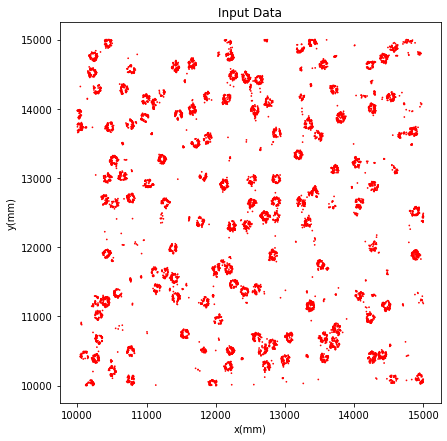

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


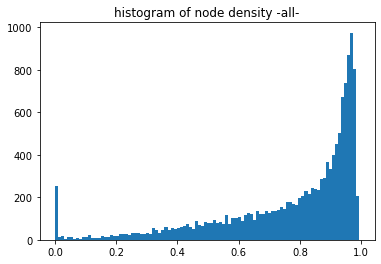

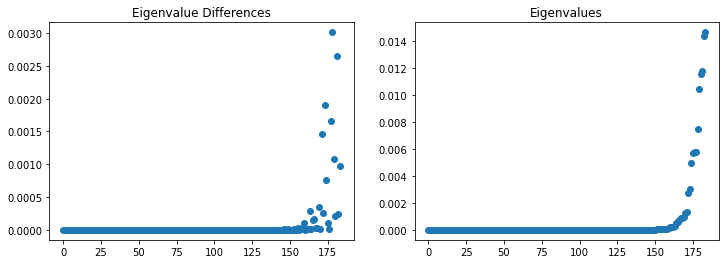

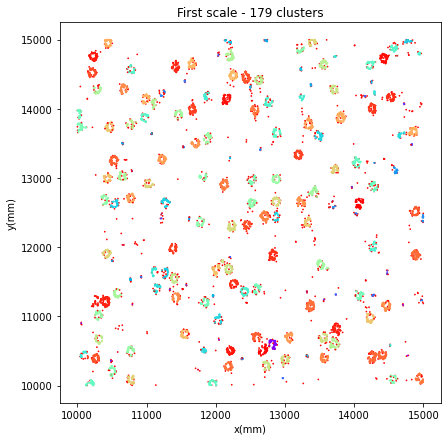

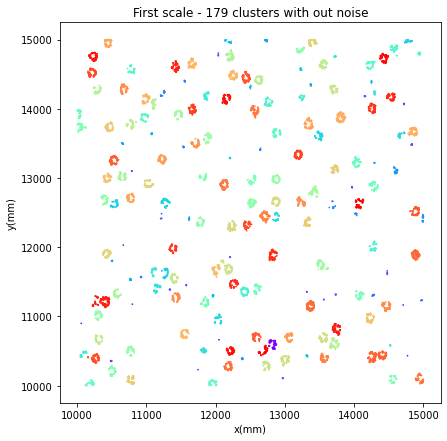

In [10]:
plot_points(P, np.zeros((P.shape[0], 1)), 'Input Data', 0.5)
density, noise_points, not_noise_points = denoise(P, Sigma, 21, 0.43, 1)
labels, G, k = cluster_single_scale(P, Sigma, not_noise_points, 21, 1)
# plot_the_graph(G, P[not_noise_points], 'Delaunay Graph', 1)
plot_points(P, labels, 'First scale - ' + str(k) + ' clusters', 0.5)
plot_points(P[not_noise_points], labels[not_noise_points], 'First scale - ' + str(k) + ' clusters with out noise', 0.5)